In [12]:
import pyspark
import math
import matplotlib.pyplot as plt
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SparkSession
from nltk.corpus import stopwords
import nltk
import cPickle as pickle
from scipy.sparse import csr_matrix
import re
import scipy
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

mypath = "../../project/cmsc25025/wikipedia/wiki-text.txt"  #Working file

In [13]:
spark = SparkSession.builder.master('local[4]').appName('assn4_prob2').getOrCreate()

In [14]:
# Create new config, I'm using a 4 cpu, 4 tasks per node, 4 node machine
spark.conf.set("spark.executor.memory", '12g')
spark.conf.set("spark.driver.maxResultSize", "12g")
spark.conf.set("spark.driver.memory", "12g")
spark.conf.set('spark.executor.cores', '2')
sc = spark.sparkContext

In [4]:
#sc.stop()

## Reduce vocabulary

In [5]:
# Download nltk corpora of stopwords
#nltk.download()

In [19]:
stop = stopwords.words("english")

In [20]:
wiki_file = open(mypath,'r').readlines()[0]
num_chunks = 40 #make it multiple of number of your cores
chunks, chunk_size = len(wiki_file), len(wiki_file) / num_chunks
wiki_chunks = [wiki_file[i:i+chunk_size] for i in range(0, chunks, chunk_size)]
#wiki_chunks[0]

In [21]:
partitions = 8
wiki_data = sc.parallelize(wiki_chunks, partitions)

In [22]:
min_ocurr = 500
vocab = wiki_data.flatMap(lambda line: line.split(" ")) \
                 .map(lambda word: (word, 1)) \
                 .reduceByKey(lambda a, b: a + b) \
                 .filter(lambda pair: pair[1] > min_ocurr and pair[0] not in stop) \
                 .collectAsMap()

In [23]:
len_voc = len(vocab)
len_voc

13201

In [24]:
voc = vocab.keys()
voc.sort() # this is our vocabulary, let's try to make some vectors now

In [25]:
voc = {w : i for i, w in enumerate(voc)}

In [26]:
k = voc.values()
k.sort()
k[-5:]

[13196, 13197, 13198, 13199, 13200]

In [27]:
pickle.dump(voc, open( "word_vocab.p", "wb" ) )

## Getting embeddings

In [ ]:
def make_matrix(word_list, size, window):
    matrix = np.zeros((size, size))
    for i in range(len(word_list) - window):
        for j in range(1, window + 1):
            matrix[voc[word_list[i]], voc[word_list[i + j]]] += 1
    return csr_matrix(matrix)

In [ ]:
# every element is a list of lists of words [[...],[...],[...]]
wiki_data = wiki_data.map(lambda chunk : [x for x in chunk.split() if (x not in stop and x in vocab)])

In [ ]:
window = 5
wc = wiki_data.map(lambda wl: make_matrix(wl, len_voc, window)).reduce(lambda x, y: x + y)

In [ ]:
#pickle.dump(wc, open( "wc.p", "wb" ) )

In [ ]:
wc = pickle.load( open( "wc.p", "rb" ) )

In [45]:
counts = wc.sum(axis=1)
D = counts.sum()
ones = np.ones((len_voc, len_voc))
div_w = ones/counts
div_c = ones/counts.T

NameError: name 'len_voc' is not defined

In [ ]:
num = np.log((wc + ones)*D)
den = -np.log(ones*counts*counts.T)
pmi = num + den

In [ ]:
U, s, V = scipy.sparse.linalg.svds(pmi, k=30)

In [27]:
# run only when needeed
pickle.dump(U, open("mtx_U.p", "wb"))
pickle.dump(s, open("mtx_s.p", "wb"))
pickle.dump(V, open("mtx_V.p", "wb"))

In [46]:
# run only when needeed
U = pickle.load(open("mtx_U.p", "rb"))
s = pickle.load(open("mtx_s.p", "rb"))
V = pickle.load(open("mtx_V.p", "rb"))

In [47]:
s_mtx = np.diag(s)

In [50]:
sroot = scipy.linalg.sqrtm(s_mtx)

In [51]:
W = U.dot(sroot) #sroot
C = sroot.dot(V)

In [52]:
pickle.dump(W, open("word_embeddings.p", "wb"))

## Embeddings & GloVe

**With our embeddings**

In [4]:
wd_matrix = pickle.load(open("word_embeddings.p", "rb"))
wd_vocab = pickle.load(open("word_vocab.p", "rb"))

In [5]:
wd_mapng = {word : np.ndarray.tolist(wd_matrix[ix]) for word, ix in wd_vocab.items()}

In [6]:
pmi_embed = spark.sparkContext.parallelize([[k] + [v] for k, v in wd_mapng.items()]).toDF(['word', 'vector'])
pmi_embed.show()

+-----------+--------------------+
|       word|              vector|
+-----------+--------------------+
|   writings|[-0.0389895769672...|
|       foul|[-0.0052673478336...|
|       four|[-0.3867115335603...|
|     prefix|[0.21274777480330...|
|      jihad|[-0.1197237236819...|
|    spiders|[-0.1270842788687...|
|     verses|[0.03608762541943...|
|  francesco|[-0.1446082153561...|
|      woody|[-0.0729551850442...|
|     cyprus|[-0.0793772227484...|
| aggression|[-0.1456184763864...|
|   marching|[-0.0650794348685...|
|    looking|[0.03774504682404...|
|     pardon|[-0.0247590092108...|
|   granting|[0.03164221241396...|
|   eligible|[-0.0404393563197...|
|electricity|[0.28539958968935...|
|    hermann|[-0.0026176771905...|
|       lord|[0.15017233205500...|
|    meadows|[-0.1154865184929...|
+-----------+--------------------+
only showing top 20 rows



** GloVe local embeddings **

In [7]:
vocab_file   = 'GloVe/wiki-vocab.txt'
vectors_file = 'GloVe/wiki-vectors.txt'
with open(vocab_file, 'r') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
with open(vectors_file, 'r') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]
vocab  = {w: idx for idx, w in enumerate(words)}
ivocab = {idx: w for idx, w in enumerate(words)}

In [8]:
lglove_embed = spark.sparkContext.parallelize([[k] + [v] for k, v in vectors.items()]).toDF(['word', 'vector'])
lglove_embed.show()

+------------+--------------------+
|        word|              vector|
+------------+--------------------+
|        fawn|[0.513643, 0.2346...|
|homomorphism|[0.176001, -0.308...|
|     nordisk|[-0.656126, 0.898...|
|     nunnery|[-0.034657, 0.333...|
|    chthonic|[0.181691, -0.530...|
|      sowell|[-1.09794, -0.682...|
|       sonja|[0.305212, 0.4386...|
|       bioko|[0.238293, -0.311...|
|      tilton|[0.097168, -0.003...|
|       askew|[-0.57191, 0.4621...|
|       woods|[0.125927, 0.2620...|
|     spiders|[-1.150668, -0.25...|
|    nordland|[0.142441, 0.4143...|
|     hanging|[0.304988, -0.219...|
|       woody|[-0.672174, 0.516...|
|     durrani|[0.183024, 0.2229...|
|   comically|[0.29354, -0.4927...|
|   localized|[0.219004, -0.059...|
|    schlegel|[0.017935, 0.7316...|
|      sevens|[-0.224682, 0.286...|
+------------+--------------------+
only showing top 20 rows



** GloVe pretrained embeddings **

In [15]:
pre_vectors_file = 'glove.6B.50d.txt'
with open(pre_vectors_file, 'r') as f:
    pre_vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        pre_vectors[vals[0]] = [float(x) for x in vals[1:]]

In [16]:
pglove_embed = spark.sparkContext.parallelize([[k] + [v] for k, v in pre_vectors.items()]).toDF(['word', 'vector'])
pglove_embed.show()

+----------+--------------------+
|      word|              vector|
+----------+--------------------+
| biennials|[0.75302, 0.80138...|
|  verplank|[-0.32867, -0.306...|
| soestdijk|[0.951, 0.23322, ...|
|     woode|[-0.88097, 0.0523...|
|      mdbo|[-0.67112, 0.9650...|
|    sowell|[-0.34872, -0.937...|
|      mdbu|[-0.93082, 1.2577...|
|     woods|[-0.090494, 0.393...|
|   spiders|[1.4794, -0.60531...|
|      mdbs|[0.40154, -0.5838...|
|      mdbr|[-0.77377, 1.3692...|
|     woody|[-0.068777, 1.062...|
|  trawling|[0.42693, -1.0779...|
|   hwasung|[-0.89039, 0.1323...|
|   spidery|[0.34241, -0.3656...|
|regularize|[0.1042, -0.5804,...|
|  hennings|[0.23447, -0.7314...|
|     canes|[-0.18691, -0.358...|
|     canet|[-0.74563, -1.039...|
|     caney|[-0.1258, 0.77926...|
+----------+--------------------+
only showing top 20 rows



### Top 5 words!
Find close words for the following: physics, republican, einstein, algebra, fish.

In [12]:
words = ['physics', 'republican', 'einstein', 'algebra', 'fish', 'elephant'] # added elephant for fun
index = ['PMI', 'local GloVe', 'pre GloVe']
rx = pd.DataFrame(index=index, columns=words)

In [118]:
import Queue
def get_top_matches(words, word_mapping, max_words):
    rv = {}
    for term in words:
        q = Queue.PriorityQueue(maxsize=max_words)
        t = np.array(word_mapping[term]).reshape(-1, 1)
        for word, embed in word_mapping.items():
            if word != term:
                res = cosine_similarity(np.array(embed).reshape(-1,1).T, t.T)[0][0]
                if q.full():
                    cs, wd = q.get()
                    if res > cs:
                        q.put((res, word))
                    else:
                        q.put((cs, wd))
                if not q.full():
                    q.put((res, word))
        w_list = []
        while not q.empty():
            w_list.append(q.get())
        rv[term] = w_list
    return rv

In [119]:
max_words = 5
rv = get_top_matches(words, wd_mapng, max_words)
rv

{'algebra': [(0.97523349193459719, 'calculus'),
  (0.97524672754441177, 'topology'),
  (0.98147946986396184, 'finite'),
  (0.98256850463864687, 'theorem'),
  (0.98565127009719711, 'algebraic')],
 'einstein': [(0.97274812034156954, 'galileo'),
  (0.97337933715638214, 'planck'),
  (0.97512847703543504, 'maxwell'),
  (0.98129824078593175, 'physicists'),
  (0.98715403301603966, 'relativity')],
 'elephant': [(0.98952828748265065, 'rat'),
  (0.98996979220692827, 'goose'),
  (0.99034762742789018, 'goat'),
  (0.99075184129253524, 'owl'),
  (0.9909860586881023, 'shark')],
 'fish': [(0.95023669511806275, 'eggs'),
  (0.95675337032454677, 'plants'),
  (0.95803712240848138, 'birds'),
  (0.95884558973288736, 'trees'),
  (0.97508738151141849, 'fruit')],
 'physics': [(0.92537613614115299, 'astronomy'),
  (0.93126754748956198, 'theoretical'),
  (0.94242776264965311, 'chemistry'),
  (0.9459591491996121, 'quantum'),
  (0.95015299112214213, 'mechanics')],
 'republican': [(0.94066103627524056, 'candidate')

In [120]:
rv = get_top_matches(words, vectors, max_words)
rv

{'algebra': [(0.70990295965868999, 'integral'),
  (0.72365645182646832, 'geometry'),
  (0.74044156603535238, 'mathematics'),
  (0.80288791308731866, 'algebras'),
  (0.81373582244578979, 'algebraic')],
 'einstein': [(0.64315231617765578, 'mechanics'),
  (0.6651079906413897, 'quantum'),
  (0.68038897119652508, 'physics'),
  (0.70215692122183071, 'maxwell'),
  (0.73474438112532325, 'relativity')],
 'elephant': [(0.63098019654857995, 'pagoda'),
  (0.64251120981867293, 'lizard'),
  (0.65955058814445577, 'elephants'),
  (0.67807722371743728, 'lion'),
  (0.72499877146833114, 'frog')],
 'fish': [(0.68887484619626682, 'eat'),
  (0.69612837349152612, 'meat'),
  (0.6982399627615633, 'shrimp'),
  (0.70943962248849068, 'food'),
  (0.71560482735624775, 'feed')],
 'physics': [(0.76035907883894371, 'quantum'),
  (0.76646101962582824, 'science'),
  (0.76675395755563591, 'mathematics'),
  (0.78625162194954235, 'mechanics'),
  (0.80088865048812174, 'chemistry')],
 'republican': [(0.71313804125612901, 'fe

In [121]:
rv = get_top_matches(words, pre_vectors, max_words)
rv

{'algebra': [(0.74395675284986618, 'associative'),
  (0.74468027839121875, 'algebras'),
  (0.75247701525018174, 'homological'),
  (0.78372211179586659, 'algebraic'),
  (0.80462524236180033, 'geometry')],
 'einstein': [(0.69716687965589497, 'freud'),
  (0.70056202293969838, 'heisenberg'),
  (0.70184532437773806, 'physics'),
  (0.72867321623401093, 'bohr'),
  (0.74389528057351251, 'relativity')],
 'elephant': [(0.76216458590932101, 'sheep'),
  (0.7658654470563685, 'deer'),
  (0.77199728418621982, 'crocodile'),
  (0.77578413449959394, 'bird'),
  (0.83063023695347049, 'elephants')],
 'fish': [(0.76385155640452795, 'bird'),
  (0.77556834830603716, 'birds'),
  (0.79814421623446286, 'shrimp'),
  (0.79954013003530477, 'meat'),
  (0.83402273498489143, 'salmon')],
 'physics': [(0.82418982944012353, 'biology'),
  (0.83143548587418936, 'science'),
  (0.84800293140417971, 'theoretical'),
  (0.87711224033747726, 'mathematics'),
  (0.89958569993349025, 'chemistry')],
 'republican': [(0.90681735525191

** Comments **
- Algebra: the three embeddings seem to suggest similar words (e.g. algebraic, algebras), but all seem pretty well related to mathematics.
- Einstein: interestingly, they all have names of physicists in their results (e.g. Maxwell, Planck); trained GloVe e. seem to have more names than concepts (e.g. mechanics, quantum, relativity).
- Fish: local GloVe e. seem to suggest only food, trained GloVe seem to suggest food/animals, and our embeddings seem to have a mix of food/animals/nature
- Physics: they all three seem to give similar results, suggesting other sciences as similar words
- Republican: our embeddings seem to suggest generic political words, local GloVe embeddings even suggest parlament members (whig) and trained GloVe suggest a very American word: GOP


### Try solving the analogy:
v = vparis − vfrance + vengland

In [11]:
from os import listdir
from os.path import isfile, join
import re

In [12]:
def solve_analogy(word_mapping, word_list):
    if not all([word in word_mapping for word in word_list]):
        return 'At least one word not in word list', 0
    v = np.array(word_mapping[word_list[0]]) - \
        np.array(word_mapping[word_list[1]]) + \
        np.array(word_mapping[word_list[2]])
    max_cos = 0
    best_match = None
    for word, embed in word_mapping.items():
        if word not in word_list:
            cosine = cosine_similarity(np.array(embed).reshape(-1,1).T, v.reshape(-1,1).T)[0][0]
            if cosine > max_cos:
                max_cos = cosine
                best_match = word
    return best_match, max_cos

In [13]:
analogy = ['paris', 'france', 'england']
solve_analogy(wd_mapng, analogy), solve_analogy(vectors, analogy), solve_analogy(pre_vectors, analogy)

(('london', 0.91976131785902027),
 ('london', 0.79805348500129736),
 ('melbourne', 0.83529067959325043))

In [14]:
analogy = ['usb', 'computer', 'floppy']
solve_analogy(wd_mapng, analogy), solve_analogy(vectors, analogy), solve_analogy(pre_vectors, analogy)

(('weighed', 0.85159092185755814),
 ('gigabyte', 0.64825133449662864),
 ('5.25-inch', 0.74353427954940854))

In [15]:
mypath = '/project/cmsc25025/assn4_analogy'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [ ]:
analogies = []
for f in onlyfiles: 
    with open(mypath + "/" + f, 'r') as f:
        for line in f:
            analogies.append(line.strip())

In [ ]:
results = {}
for a in analogies:
    w_list = re.findall(r'([a-zA-z]+):([a-zA-z]+)=([a-zA-z]+)', a)[0]
    print(w_list)
    print("Analogy: {}.".format(a))
    pmi = solve_analogy(wd_mapng, w_list)
    lgv = solve_analogy(vectors, w_list)
    tgv = solve_analogy(pre_vectors, w_list)
    results[a] = [pmi, lgv, tgv]
    print(results[a])

('segregate', 'unify', 'damage')
Analogy: segregate:unify=damage:?.
[('At least one word not in word list', 0), ('At least one word not in word list', 0), ('inhalation', 0.74240927758319131)]
('argentina', 'brazil', 'iran')
Analogy: argentina:brazil=iran:?.
[('afghanistan', 0.97912003591445507), ('kuwait', 0.73339595020199422), ('korea', 0.83021732907319856)]
('ashes', 'urn', 'money')
Analogy: ashes:urn=money:?.
[('At least one word not in word list', 0), ('raise', 0.70964412968903656), ('helped', 0.81395785818691901)]
('telephone', 'cord', 'television')
Analogy: telephone:cord=television:?.
[('tv', 0.90585625103312961), ('radio', 0.80311476502335644), ('news', 0.80894156531360839)]
('walk', 'roam', 'speak')
Analogy: walk:roam=speak:?.
[('At least one word not in word list', 0), ('words', 0.65308640324122524), ('telling', 0.7753847568157316)]
('novel', 'epilogue', 'meal')
Analogy: novel:epilogue=meal:?.
[('At least one word not in word list', 0), ('eaten', 0.62531593216140524), ('food'

In [ ]:
pickle.dump(results, open("analogies.p", "wb"))

**Comments**

The analogy fails if at least one word of the analogy is not found in the vocabulary. We could solve this by using something like the closest similar word, or increase the size of the dictionary.

Some of the results make some sense, and are interesting:

- day:night = up:rest (makes sense, I rest when I'm not up haha)
- poetry:poet = music:musical
- war:weapon = peace:union

Some miss it by a little:

- judaism:rabbi = christianity:catholicism (more like priest?)
- knight:squire = professor:doctor (shouldn't it be the other way around?)
- breakfast:morning = dinner:snack (not completely wrond, but probably night was better)
- russia:moscow = china:korea (wrong, but at least is a geopolitical word)

A few are very weird and totally miss it:

- cereal:milk = butter:carpets (Mom would definitely kill me)
- Ireland:potatoes=italy:kingdom
- man:woman = mr:sam (LOL)
- smart:intelligent=sly:doris (like, from Nemo?)
- fire:firefighter = doctor:zhivago
- federer:tennis=ronaldo:solidifies

It's interesting to see that sometimes our embeddings give better (maybe more expected?) answers than the GloVe ones, for example:
- beer:alcohol=marijuana: (pizza <- pmi, oxfam <- local Glove, cigar <- pretrained Glove)
- boy: girl=man: (woman, evil, him)
- dice:roll=coin: (coinage, coins, reales) 

other it just fails miserably:
- good:better=bad: (saying, my, little)
- ice:fire=cold (climate, wet, melt)

To make a "good" analogy solver, we might need more text (in terms of topics maybe? or maybe just quantity). Also, Maybe increase the dimensionality of our embeddings (we picked 30, but could've done it with slightly more.
Also, a bad thing about our pmi embeddings is that there are many words in the analogies that are not in our vocabulary, so we really can't compute anything.


## t-sne

In [17]:
%matplotlib notebook
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
# pre_vectors is a dict with (words: vectors) kv pairs
l = [(k, v) for k, v in pre_vectors.items()][:1000]
Y = tsne.fit_transform([x[1] for x in l])

<IPython.core.display.Javascript object>


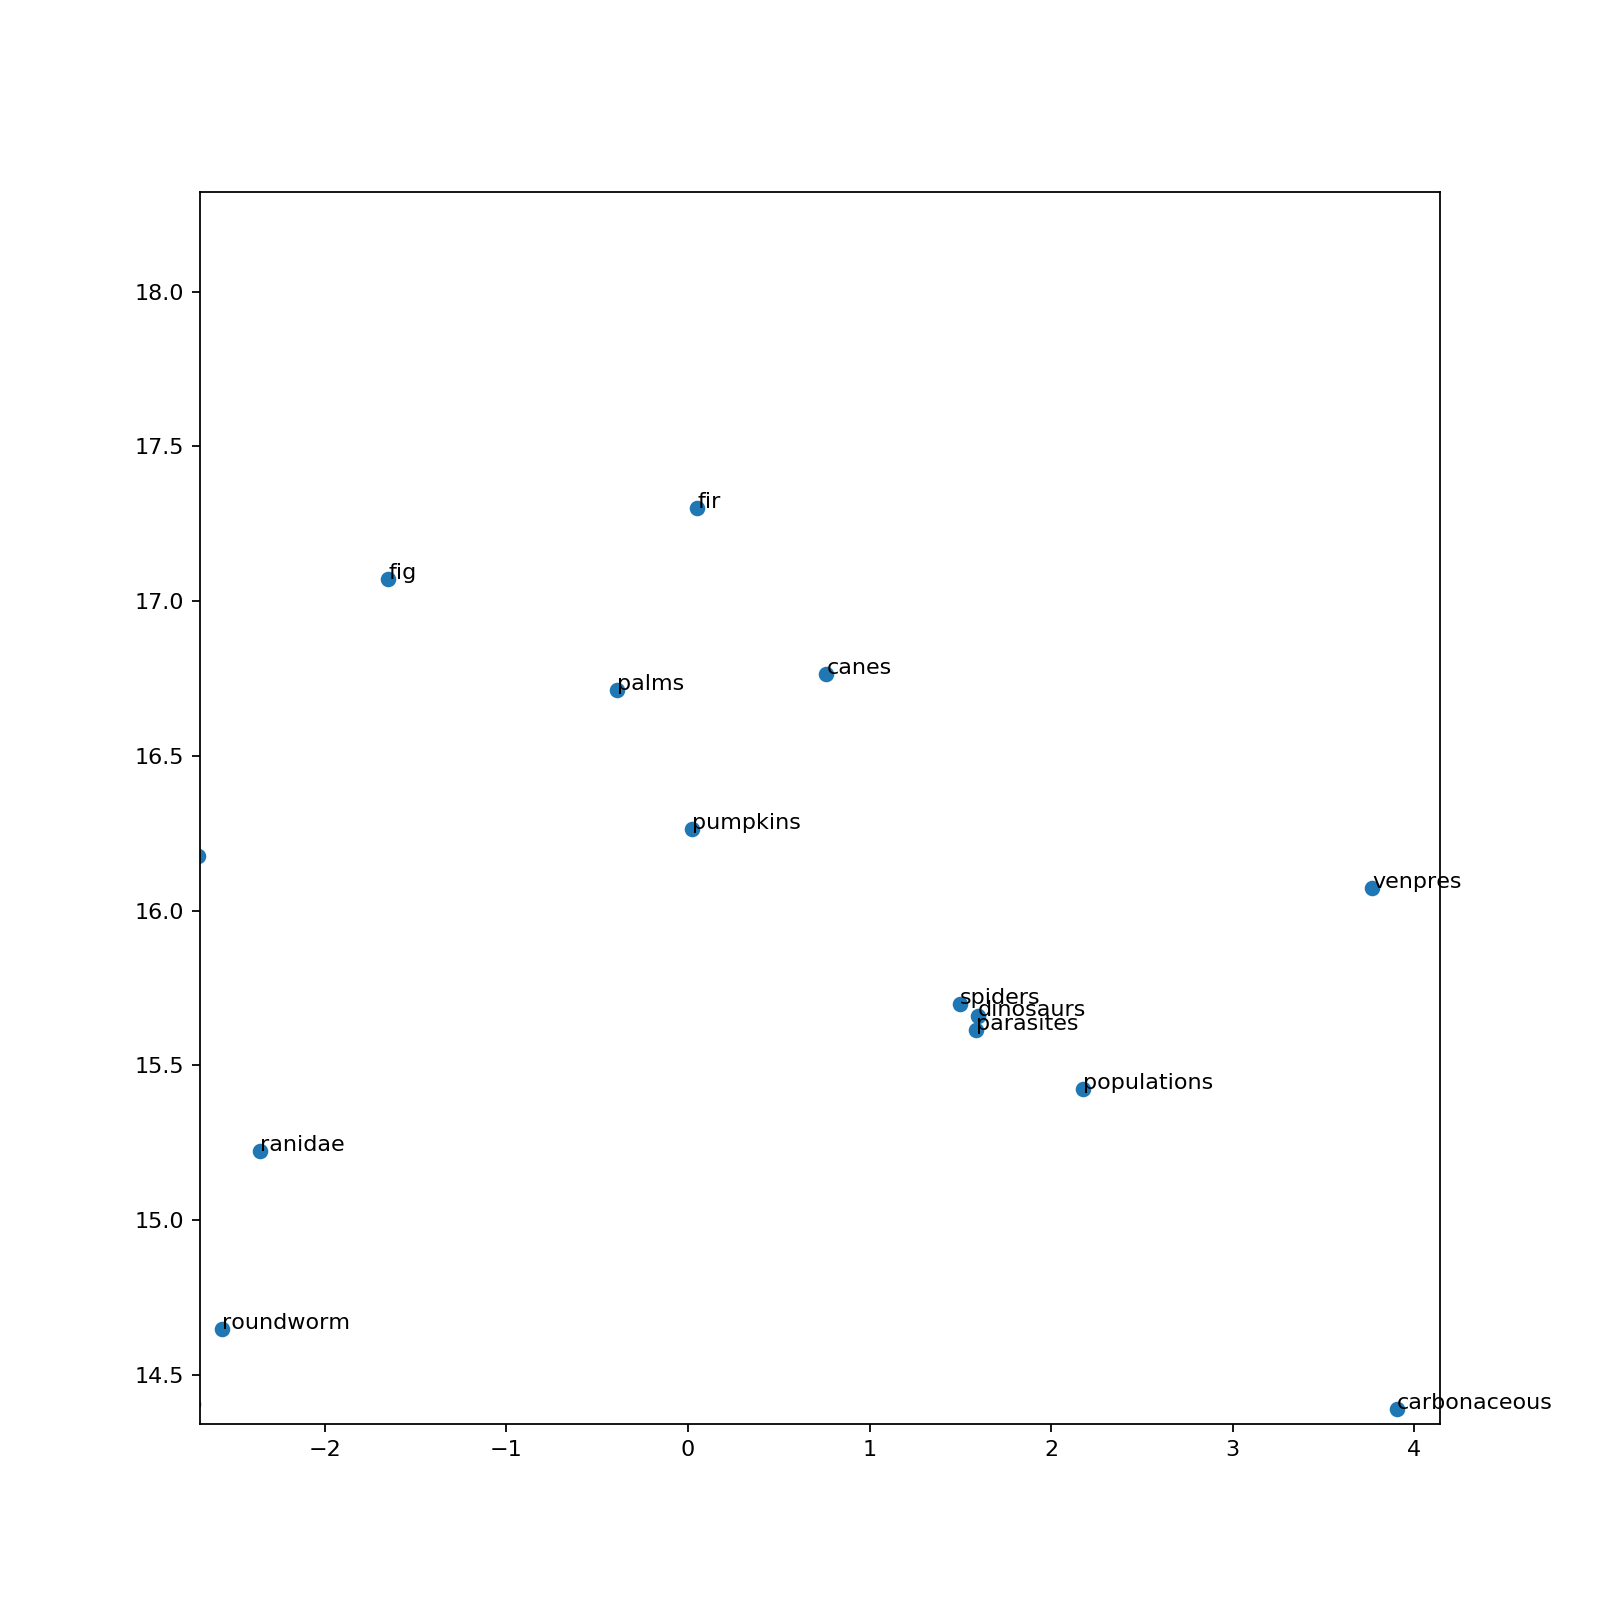

In [22]:
plt.figure(figsize=(10,10))
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip([x[0].decode('utf-8') for x in l], Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()
## image name is words.png in the submission folder

** Comments **

It seems there is an interesting cluster of nature-related words in the top part of the blob:
    - populations,
    - spiders, 
    - dinosaurs, 
    - parasites

which are all pretty close to:
    - palms
    - pumpkins
    - cane
    - fir
    - fig
   
It's also cool to see that carbonaceous (maybe from the geological eras?) is close to dinosaur!